In [1]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


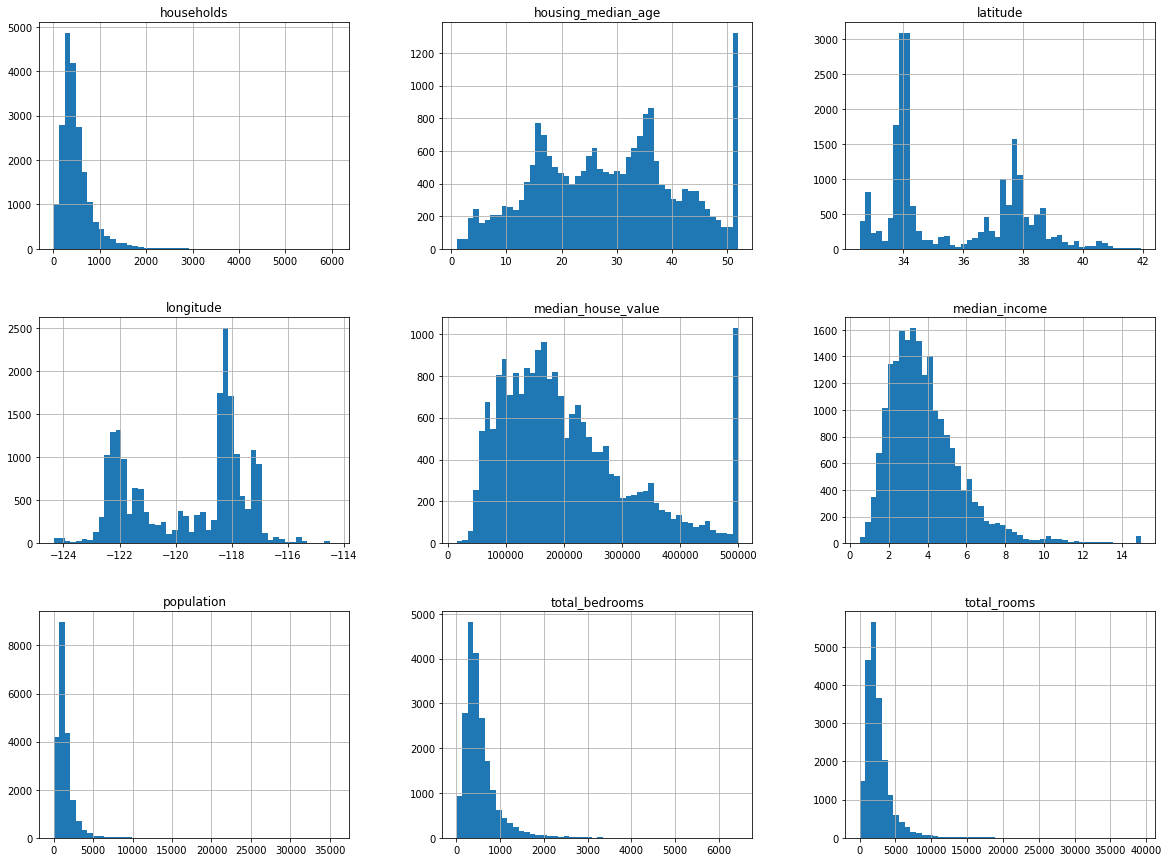

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [9]:
import numpy as np
import numpy.random as rnd

def split_train_test(data, test_ratio):
    """
    Simple way to split data into train and test set.
    
    The seed value ensures a consistent split across runs,
    provided the dataset is the same.
    """
    rnd.seed(42)
    shuffled_indices = rnd.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train, test = split_train_test(housing, 0.2)

In [11]:
len(train), len(test)

(16512, 4128)

In [12]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    """Compute hash of identifer and """
    return hash(str(identifier).encode('utf-8')).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
housing_with_id = housing.reset_index()
# Use the data's index (aka position) to generate the consistent id.
# Problem with this approach is it assumes data is only ever appended and never
# changes.
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [14]:
len(train_set), len(test_set)

(16432, 4208)

In [15]:
# Better approach might be to use something consistent like the lon/lat.
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

* The above approaches to splitting are random sampling methods. Some datasets shouldn't be randomly sampled.
  * Consider dataset with a 30% / 70% split of category assignment. Maybe you want to preserve that in your train / test split?
  * Enter: stratified sampling.
* Stratified sampling:
  * Data is assigned into homogenous groups called "strata".
* Example: housing price dataset has various categories of incomes that should be represented in dataset:

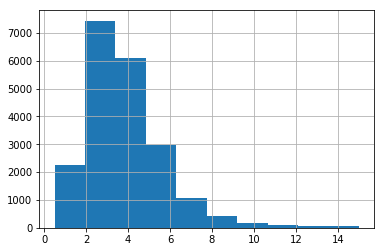

In [16]:
housing['median_income'].hist()

* Most people fall into the 20-30k income buckets, need to represent them in your dataset.
* ``StratifiedShuffleSplit`` handles this for you, given category labels:

In [17]:
# Assign data into buckets and add anything above 5 into the same bucket.
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

from sklearn.cross_validation import StratifiedShuffleSplit

split = StratifiedShuffleSplit(housing["income_cat"], test_size=0.2)
train_indices, test_indices = next(iter(split))
strat_train_set = housing.loc[train_indices]
strat_test_set = housing.loc[test_indices]

housing['income_cat'].value_counts() / len(housing)

/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

Note, the distribution of the test set is simiar to the whole dataset:

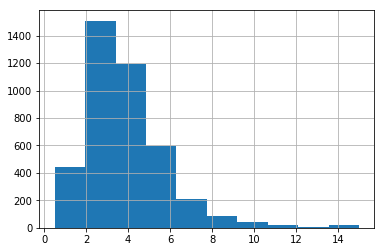

In [18]:
strat_test_set['median_income'].hist()

Create a copy of the dataset, to avoid harming the original:

In [19]:
housing = strat_train_set.copy()

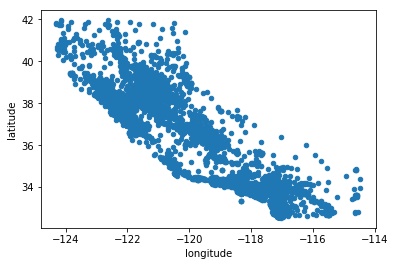

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Set alpha to 0.1 to make it easier to visualise high density points:

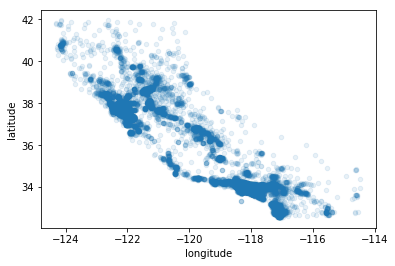

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Another improvement: Radius of each circle represents the district population and colour for the price. Uses a built in colour map called "jet".

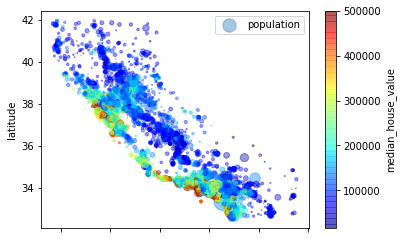

In [22]:
housing.plot(
    kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"] / 100, label="population",
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True
)
plt.legend()

Can use the "standard correlation coefficient" (aka Pearson's r) to determine correlation between every pair of attributes, as follows:

In [23]:
corr_matrix = housing.corr()

In [24]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687444
income_cat            0.642504
total_rooms           0.134736
housing_median_age    0.100349
households            0.066135
total_bedrooms        0.048853
population           -0.023135
longitude            -0.044848
latitude             -0.144215
Name: median_house_value, dtype: float64

Can also check for correlations using Pandas' scatter_matrix function

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10eb8b588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10ea20f98>]], dtype=object)

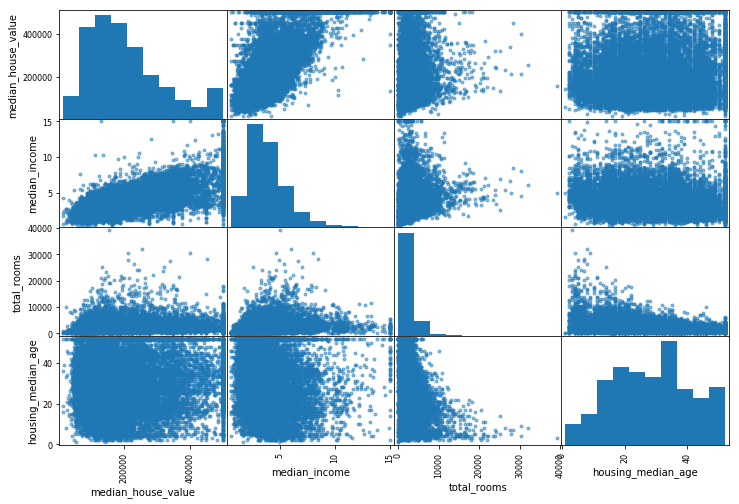

In [25]:
from pandas.tools.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing[attributes], figsize=(12, 8))

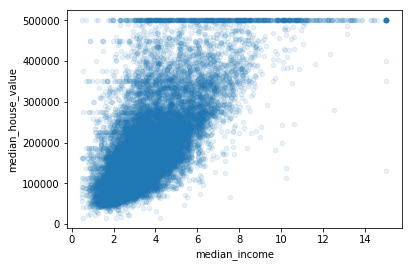

In [26]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

Some other correlations to try out: number of rooms per household, bedrooms per room and population per household:

In [27]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['population']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [28]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687444
income_cat                  0.642504
rooms_per_household         0.202108
total_rooms                 0.134736
housing_median_age          0.100349
households                  0.066135
total_bedrooms              0.048853
population_per_household   -0.021676
population                 -0.023135
longitude                  -0.044848
latitude                   -0.144215
bedrooms_per_room          -0.255089
Name: median_house_value, dtype: float64

Revert to a clean training set:

In [29]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

Options for working with missing features values:

1. Get rid of whole attribute.
2. Set values to some value (0, mean etc)

In [30]:
median = housing['total_bedrooms'].median()
housing['total_bedrooms'].fillna(median)

1171      383.0
20217     373.0
17392     445.0
4977      387.0
2177      245.0
11836     906.0
20154     381.0
19378      86.0
5598      327.0
15628     568.0
11872     261.0
16980     436.0
6583      263.0
16105     435.0
2997      549.0
1614      760.0
15980     165.0
12041    2238.0
7380      263.0
2863      433.0
4633     1707.0
11996     935.0
429       200.0
5207      461.0
3425      308.0
12796     295.0
18683     705.0
7876      982.0
16893     226.0
9201      424.0
          ...  
10649    1292.0
10951     598.0
3192      214.0
14401     442.0
18893    1084.0
11036     667.0
7698      348.0
9781      443.0
2817      516.0
12874    1507.0
4611      815.0
10250     328.0
19697     548.0
18810     537.0
7428      328.0
4156      398.0
10862     654.0
215       711.0
9277      871.0
8757      339.0
7784      463.0
374       275.0
3011      168.0
12110     769.0
8139      233.0
20368     716.0
6061     2862.0
7587      553.0
2117      282.0
1695      166.0
Name: total_bedrooms, dt

Scikit-Learn provides a call for taking care of missing values called "Imputer". To use it:

1. Remove any non-numeric attributes (Imputer only works on numeric).
2. Create instance of Imputer with strategy and fit to data.

In [31]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')

housing_only_num = housing.drop('ocean_proximity', axis=1)

imputer.fit(housing_only_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [32]:
imputer.statistics_

array([ -118.48  ,    34.25  ,    29.    ,  2130.    ,   435.    ,
        1167.    ,   409.    ,     3.5391,     3.    ])

In [33]:
X = imputer.transform(housing_only_num)

In [34]:
# Convert back to a Pandas dataframe
housing_tr = pd.DataFrame(X, columns=housing_only_num.columns)

In [35]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
0,-121.58,39.50,29.0,1947.0,383.0,925.0,337.0,2.1658,2.0
1,-119.25,34.28,36.0,2232.0,373.0,951.0,368.0,5.2261,4.0
2,-120.45,34.96,21.0,2121.0,445.0,2211.0,463.0,4.0603,3.0
3,-118.29,34.00,44.0,1753.0,387.0,1165.0,380.0,2.1354,2.0
4,-119.85,36.75,24.0,1143.0,245.0,608.0,240.0,2.8194,2.0
5,-120.98,39.08,20.0,4570.0,906.0,2125.0,815.0,3.0403,3.0
6,-119.19,34.46,39.0,2056.0,381.0,939.0,371.0,6.6257,5.0
7,-120.69,37.77,46.0,431.0,86.0,239.0,80.0,3.3182,3.0
8,-118.27,33.80,38.0,1446.0,327.0,980.0,319.0,3.3500,3.0
9,-122.40,37.80,52.0,2094.0,568.0,920.0,503.0,4.2015,3.0


## Handling text and categorical attributes

* Scikit has a transformed called ``LabelEncoder`` that can be used to convert labels to numbers.

In [36]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([1, 4, 0, ..., 0, 1, 3])

In [37]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)

* Issue with this representation: ML algorithms may assume nearby values are meaningful (eg 0 and 1 are more similar than 0 and 4).
  * Fix it using 1-hot encoding: each possibilities are columns and they are either yes or no (1 or 0).

In [38]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

* Returns a sparse matrix so the zeros (of which there are a lot) don't take up any space.

* Can apply both transformation: text to integer, integet to one-hot using ``LabelBinarizer`` class:

In [39]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       ..., 
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0]])

## Custom transformers

* Just need to implement 3 methods: ``fit()``, ``transform()`` and ``fit_transform()``.
  * If you inherit from ``TransformerMixing``, you can ``fit_transform()`` for free.
  * If you add ``BaseEstimator`` as base class, you get ``get_params()`` and ``set_params()`` - useful for hyperparam tuning.
* Example of adding extra attributes using custom transformer:

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]

In [41]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Feature scaling

* Most ML algoritms don't work well with features of different scales.
* 2 common ways to solve it:
  1. Min-max scaling.
  2. Standardization.
  
* Min-max:
  * subtract the min and divide by max-min.
    ```
    (value - min(values)) / max(values) - min(values)
    ```
  * Provided by Scikit as ``MinMaxScaler``.
* Standardization:
  * Subtract the mean and divide by the variance.
  * Less affected by outliers than min-max.
  * Provided by Scikit as ``StandardScaler``.

## Transformation pipelines

* Run a series of transformations.

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('attribs_addr', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

* Can join multiple transformation pipelines using a ``FeatureUnion`` class.

In [44]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_only_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy='median')),
    ('attribs_addr', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [45]:
housing_prepared = full_pipeline.fit_transform(housing)

* Train first linear regression model:

In [46]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68076.0853509843

* Result indicates we have a root mean squared error of $68k. Not a great result.
  * Indicates overfitting.
  
* Trying out a ``DecisionTreeRegressor`` yields no error. Very likely overfitting:

In [48]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

* Cross-validation can be useful for evaluating model.
  * Random splits data set into 10 distinct subsets called "folds".
  * It runs training 10 times, picking 9 folds to use for training and one for evaluation.

In [49]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(
    tree_reg, housing_prepared, housing_labels, scoring='mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: Deprecat

In [50]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())
    
display_scores(tree_rmse_scores)

Scores:  [ 73651.24957013  73324.82628305  76017.90866926  70740.33567143
  66347.00170989  68824.33584693  72519.26810552  68518.00740316
  75101.99801233  70503.25788175]
Mean:  71554.8189153
Standard deviation:  2941.56497574


In [51]:
lin_scores = cross_val_score(
    lin_reg, housing_prepared, housing_labels,
    scoring="mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: Deprecat

Scores:  [ 68326.15330564  69355.66745184  69935.14111396  69365.217275
  73591.2144789   66891.70255438  68000.8601807   65520.59398059
  67274.07041823  67483.80620253]
Mean:  68574.4426962
Standard deviation:  2090.06800765


/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


* Can see that the ``DecisionTreeRegressor`` performed worse than Linear Regression because of overfitting.
* Another attempt: Random Forest.
  * RF trains a bunch of decision trees on random subsets of the data and often yields strong perform.

In [52]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
lin_scores = cross_val_score(
    forest_reg, housing_prepared, housing_labels,
    scoring="mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-lin_scores)
display_scores(forest_rmse_scores)

/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: Deprecat

Scores:  [ 51319.12584344  52022.64385419  55243.75603728  50995.4407346
  50874.35845263  51995.77921989  53989.75118107  50813.80228627
  53570.94022943  51881.85102953]
Mean:  52270.7448868
Standard deviation:  1427.48873345


/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


* Before you dive too far into one algorithm, ensure you shortlist around 2 - 5 other potentials.
* Can save models using the ``joblib`` library.

### Grid search

* ``GridSearchCV`` can do automatic hyperparameter tuning.
   * If you have no idea what hyperparameter value to use, try consecutive powers of 10.

In [53]:
from sklearn.grid_search import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(
    forest_reg, param_grid, cv=5, scoring='mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/lex/code/study-notes/books/hands-on-machine-learning/ENV/lib/python3.6

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

* Param grid is a list of hyperparameters to try in combination.
  1. 3 n_estimator * 4 max_features
  2 2 * 3 with bootstrap set to False.
* Grid search explores 12 + 6 = 18 combinations of RandomForestRegression, and trains each model 5 times.
* Can use ``best_params_`` attribute to find best params discovered and ``best_estimator_`` to find the best estimator.

In [57]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'max_features': 8, 'n_estimators': 30}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


### Randomized search

* Use ``RandomizedSearchCV`` when the hyperparameter search space is large.
* Instead of evaluating a bunch of combinations, it tries all combos up to some max iterations.

### Analyze best models and their errors

* Inspect models to gain insights into the best features.

In [58]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.33178320226662655, 'median_income'),
 (0.12577165417460004, 'INLAND'),
 (0.11419044721111653, 'income_cat'),
 (0.11147527433235875, 'pop_per_hhold'),
 (0.062767392814968404, 'longitude'),
 (0.060975827797232353, 'latitude'),
 (0.042813764436975786, 'housing_median_age'),
 (0.038479889652941655, 'bedrooms_per_room'),
 (0.036585187872255398, 'rooms_per_hhold'),
 (0.016198496376566236, 'population'),
 (0.015383382951016124, 'total_rooms'),
 (0.015273835446543147, 'total_bedrooms'),
 (0.014757502287463756, 'households'),
 (0.0075309383097244831, '<1H OCEAN'),
 (0.004116921454446548, 'NEAR OCEAN'),
 (0.0016896353594853669, 'NEAR BAY'),
 (0.00020664725567880741, 'ISLAND')]

* Can see that median income and whether it's inland or not are the most influential features in the model.

### Evaluate on the test set

* Get the predictors and labels from test set, run pipeline and evaluate the model.

In [62]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

50290.1850629


## Launch, monitor and maintain system

* Write monitoring to check system's live performance at reg intervals.
  * May require human analysis to evaluate the model.
* Also want to monitor you inputs (signals, another team's output etc).
* Retrain your models on an ongoing basis.

## Exercises

### 1. Suppoer